# Gradient meets attention
Generates Figure 5 of the paper Attention Meets Post-hoc Interpretability: A Mathematical Perspective.

In [1]:
import os
import pickle
import itertools 

import torch
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import math

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from lime import lime_text

import re

In [2]:
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)
plt.rcParams.update({'font.size': 18})

In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
from models.utils import get_g_values
from models.utils import scaled_dot_product
from data.dataset import Dataset
import params

In [5]:
import sys
sys.path.append("C:/Users/gianl/Anaconda3/bin")

In [6]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model name and path
model_name = 'multi_head_e\\model'
model_path = os.path.join('.', 'models', 'saved', 'IMDB', model_name)

# Load the classifier model
with open(os.path.join(model_path, 'classifier.pkl'), 'rb') as inp:
    classifier = pickle.load(inp)
print(f"Model loaded successfully from: {model_path}")

Using device: cpu
Model loaded successfully from: .\models\saved\IMDB\multi_head_e\model


In [7]:
example = "attention based explanations are popular but questionable"

classifier.predict_proba([example])

array([[-0.64168686,  0.58398646]], dtype=float32)

In [8]:
example

'attention based explanations are popular but questionable'

In [9]:
unk_string = ' '.join([params.MASK for i in range(params.MAX_LEN-1)])

In [10]:
# Preprocess the input sentence
x = torch.stack([classifier.preprocess(example)])

v, q, k, attention, g_u = [], [], [], [], []
W_k, W_q, W_v, W, q_cls = [], [], [], [], []

    
emb = classifier.embedding(x.to(torch.int64))
e = classifier.pe(emb)

for h in range(params.NUM_HEADS):
    # Transform the sentence embedding using the embedding layer
    head = classifier.heads[h]


    # Extract query, key, and value representations from the embedding
    q.append(head.query(e))
    k.append(head.key(e))
    v.append(head.value(e))

    W_k.append(head.key(torch.eye(e.shape[-1])))
    W_q.append(head.query(torch.eye(e.shape[-1])))
    W_v.append(head.value(torch.eye(e.shape[-1])))
    W.append(head.classifier(torch.eye(v[h].shape[-1]))[:, 1])
    q_cls.append(q[h][:, classifier.cls_pos, :])

    # Calculate scaled dot-product attention
    values, alpha, g = scaled_dot_product(q[h], k[h], v[h], return_g=True, scale=True)
    
    attention.append(alpha)
    g_u.append(g[:, classifier.cls_pos, :])
    
    # Extract attention-weighted values for the classifier layer
    cls_values = values[:, classifier.cls_pos, :]

    # Pass the attention-weighted values through the classifier to obtain predictions
    output = head.classifier(cls_values)

    print(output)

tensor([[-1.9244,  2.2145]], grad_fn=<MmBackward0>)
tensor([[ 0.7073, -0.7996]], grad_fn=<MmBackward0>)
tensor([[-2.8908,  3.1665]], grad_fn=<MmBackward0>)
tensor([[ 1.8753, -2.5159]], grad_fn=<MmBackward0>)
tensor([[-1.4783,  0.8150]], grad_fn=<MmBackward0>)
tensor([[-0.1392,  0.6234]], grad_fn=<MmBackward0>)


In [11]:
d_k = params.ATTN_DIM
n_heads = params.NUM_HEADS

In [12]:
# Preprocess the "UNK" token
x_unk = torch.stack([classifier.preprocess(unk_string)])

v_unk, q_unk, k_unk, g_unk = [], [], [], []

# Convert the "UNK" token to embedding representation
emb = classifier.embedding(x_unk.to(torch.int64))
e_unk = classifier.pe(emb)

for h in range(params.NUM_HEADS):

    # Extract the hidden state (h) from the "UNK" token embedding
    v_unk.append(classifier.heads[h].value(e_unk)) 
    q_unk.append(classifier.heads[h].query(e_unk))
    k_unk.append(classifier.heads[h].key(e_unk)) 
    
    d_k = q_unk[h].size()[-1]
    attn_logits = torch.matmul(q[h], k_unk[h].transpose(-2, -1)) / math.sqrt(d_k)
    g_unk.append(torch.exp(attn_logits)[:, classifier.cls_pos, :])

In [13]:
grad_theory = []
for h in range(n_heads):
    grad_head = []

    for t in range(params.MAX_LEN):     
        p1 = torch.matmul(q_cls[h], W_k[h].T) / math.sqrt(d_k) * torch.matmul(v[h][:, t, :], W[h])
        p2 = torch.matmul(W[h], W_v[h].T)
        n1 = torch.sum(torch.stack([attention[h][:, classifier.cls_pos, s] * 
                                         torch.matmul(q_cls[h], W_k[h].T) / math.sqrt(d_k) * 
                                         torch.matmul(v[h][:, s, :], W[h])
                                         for s in range(params.MAX_LEN)]), dim=0)

        grad_head.append((attention[h][:, classifier.cls_pos, t]) * (p1 + p2 - n1))
        
    grad_theory.append(torch.cat(grad_head))

In [14]:
torch.stack(grad_theory).shape

torch.Size([6, 256, 128])

In [15]:
torch.mean(torch.stack(grad_theory), dim=0)

tensor([[-1.0511e-01, -2.9445e-02,  5.7189e-02,  ...,  7.9856e-02,
         -9.5229e-02, -3.0264e-01],
        [ 4.4375e-04, -2.3625e-04, -1.1520e-03,  ...,  8.6789e-03,
          6.3203e-03,  6.8574e-04],
        [ 2.7160e-02,  1.7591e-02, -4.2354e-02,  ...,  9.9584e-02,
          4.4732e-02, -4.5896e-02],
        ...,
        [ 2.3949e-04,  1.9903e-04,  1.5449e-04,  ..., -2.9668e-04,
         -1.4545e-04,  1.2914e-04],
        [ 1.9137e-04,  1.6650e-04,  1.4803e-04,  ..., -2.7715e-04,
         -1.2557e-04,  1.7253e-04],
        [ 1.9224e-04,  1.6840e-04,  2.5337e-04,  ..., -3.4953e-04,
         -1.6771e-04,  3.1299e-04]], grad_fn=<MeanBackward1>)

In [16]:
grad = {}

def get_gradient(name):
    def hook(model, grad_input, grad_output):
        grad[name] = grad_output[0].detach()
    return hook
        
handle_gradient_pe = classifier.pe.register_full_backward_hook(get_gradient('pe'))

Z = classifier(x)

Z[0,1].backward()

# Print output and gradients
gradient_e = torch.squeeze(grad['pe'])
print(Z)

print(gradient_e)

tensor([[-0.6417,  0.5840]], grad_fn=<DivBackward0>)
tensor([[-1.0361e-01, -2.2006e-02,  6.3245e-02,  ...,  5.0508e-02,
         -1.3956e-01, -3.1812e-01],
        [ 4.4375e-04, -2.3625e-04, -1.1520e-03,  ...,  8.6789e-03,
          6.3203e-03,  6.8574e-04],
        [ 2.7160e-02,  1.7591e-02, -4.2354e-02,  ...,  9.9584e-02,
          4.4732e-02, -4.5896e-02],
        ...,
        [ 2.3949e-04,  1.9903e-04,  1.5449e-04,  ..., -2.9668e-04,
         -1.4545e-04,  1.2914e-04],
        [ 1.9137e-04,  1.6650e-04,  1.4803e-04,  ..., -2.7715e-04,
         -1.2557e-04,  1.7253e-04],
        [ 1.9224e-04,  1.6840e-04,  2.5337e-04,  ..., -3.4953e-04,
         -1.6771e-04,  3.1299e-04]])


In [17]:
torch.mean(torch.stack(grad_theory), dim=0)

tensor([[-1.0511e-01, -2.9445e-02,  5.7189e-02,  ...,  7.9856e-02,
         -9.5229e-02, -3.0264e-01],
        [ 4.4375e-04, -2.3625e-04, -1.1520e-03,  ...,  8.6789e-03,
          6.3203e-03,  6.8574e-04],
        [ 2.7160e-02,  1.7591e-02, -4.2354e-02,  ...,  9.9584e-02,
          4.4732e-02, -4.5896e-02],
        ...,
        [ 2.3949e-04,  1.9903e-04,  1.5449e-04,  ..., -2.9668e-04,
         -1.4545e-04,  1.2914e-04],
        [ 1.9137e-04,  1.6650e-04,  1.4803e-04,  ..., -2.7715e-04,
         -1.2557e-04,  1.7253e-04],
        [ 1.9224e-04,  1.6840e-04,  2.5337e-04,  ..., -3.4953e-04,
         -1.6771e-04,  3.1299e-04]], grad_fn=<MeanBackward1>)

## Visualization

In [18]:
grad_f_theory = torch.mean(torch.stack(grad_theory), dim=0).detach().numpy()
grad_f_practice = gradient_e.detach().numpy()

In [19]:
tokens = classifier.tokenizer(example)
labels = ['[CLS]'] + tokens 
num_tokens = 10
print(labels)

['[CLS]', 'attention', 'based', 'explanations', 'are', 'popular', 'but', 'questionable']


In [20]:
num_e = 80

# Define a custom colormap for visualization
cmap = colors.LinearSegmentedColormap.from_list("", ["red","white","green"])

# Compute the global minimum and maximum of the data
gmin = min(grad_f_theory[1:num_tokens, :num_e].min(), grad_f_practice[1:num_tokens, :num_e].min())
gmax = max(grad_f_theory[1:num_tokens, :num_e].max(), grad_f_practice[1:num_tokens, :num_e].max())

# Define the color range for the colormap
vmax = min(abs(gmax), abs(gmin)) 
vmin = -vmax

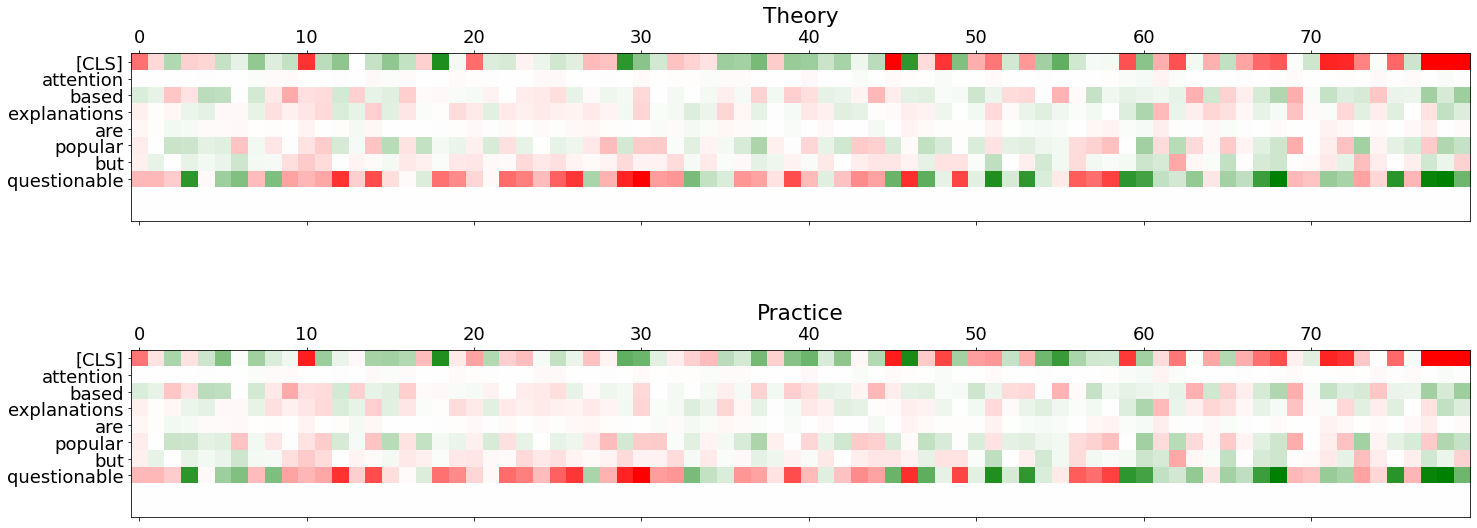

In [21]:
# Initialize a figure with a specific size
fig = plt.figure(figsize=(24,10))

# Create the first subplot for the theoretical gradient
ax1 = fig.add_subplot(2, 1, 1)
mappable = ax1.matshow(grad_f_theory[:num_tokens, :num_e], cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_yticks(range(len(labels)))
ax1.set_yticklabels(labels)
ax1.set_title('Theory')

# Create the second subplot for the practical gradient
ax2 = fig.add_subplot(2, 1, 2)
mappable = ax2.matshow(grad_f_practice[:num_tokens, :num_e], cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_yticks(range(len(labels)))
ax2.set_yticklabels(labels)
ax2.set_title('Practice')

# Save the figure as a PDF file with a tight layout
plt.savefig('results/paper/gradient_meets_attention.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

# Display the figure
plt.show()